# Lab 2 Samuel Bieberich

In [33]:
#imports

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## 1. Signal to Noise Ratio


### Generate a tone with frequency 2 MHz and amplitude 1 V. Sample the tone at frequencies Fs = 5 MHz.


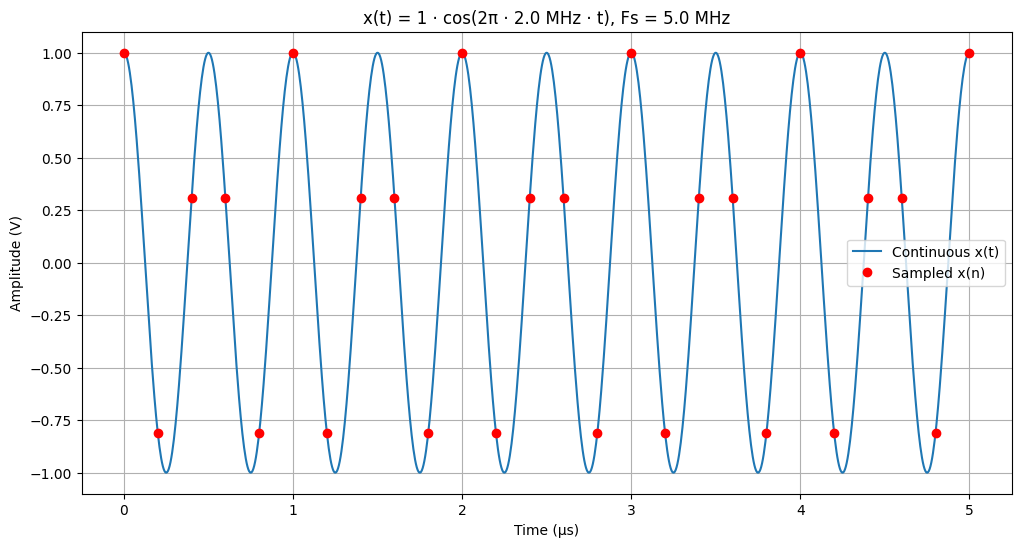

In [34]:
F = 2e6  
Fs = 5e6  
A = 1    

t = np.linspace(0, 5e-6, 1000) 

x = A * np.cos(2 * np.pi * F * t)

n = np.arange(0, 26) #12 is sample number 
ts = n / Fs

xs = A * np.cos(2 * np.pi * F * ts)

plt.figure(figsize=(12, 6))

plt.plot(t*1e6, x, label='Continuous x(t)')
plt.plot(ts*1e6, xs, 'ro', label='Sampled x(n)')
plt.title(f'x(t) = {A} · cos(2π · {F/1e6} MHz · t), Fs = {Fs/1e6} MHz')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)

plt.show()


### (a) Add Gaussian noise
- Add Gaussian noise to the sampled sinewave such that the signal SNR is 50 dB.
- Find first the variance of the Gaussian noise needed to produce the target SNR.
- Calculate and plot the Power Spectral Density (PSD) from the DFT of the noisy samples.
- Corroborate that the SNR calculation from the DFT plot gives the theoretical result.
- What would be the variance of a uniformly distributed noise to obtain the same SNR?

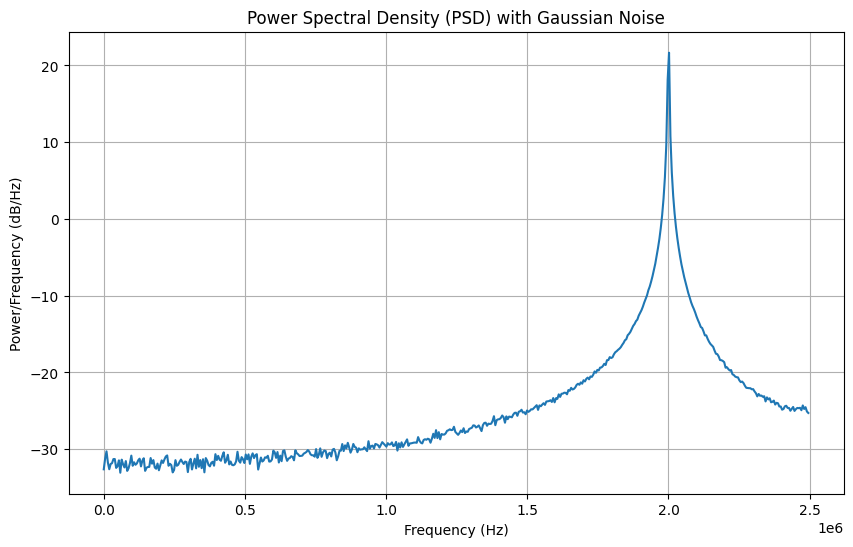

SNR from PSD: 38.95 dB
Theoretical SNR: 50.00 dB
Amplitude of uniformly distributed noise: 0.01
Variance of uniformly distributed noise: 5.00e-06


In [ ]:
SNR_target_dB = 50  
N = 1024 

t = np.arange(0, N/Fs, 1/Fs)  

x = A * np.cos(2 * np.pi * F * t)
signal_power = np.mean(x**2)

SNR_target_linear = 10**(SNR_target_dB / 10)
noise_power = signal_power / SNR_target_linear

noise_std = np.sqrt(noise_power)

noise = np.random.normal(0, noise_std, len(x)) # Generate N samples of noise
noisy_signal = x + noise

# --- PSD Calculation and Plotting ---
def calculate_psd(signal, Fs):
    """Calculates the Power Spectral Density (PSD) using DFT."""
    fft = np.fft.fft(signal)
    psd = np.abs(fft)**2 / N  
    freq = np.fft.fftfreq(len(signal), 1/Fs)
    positive_freq_indices = np.where(freq >= 0)
    freq = freq[positive_freq_indices]
    psd = psd[positive_freq_indices]
    return freq, psd

freq, psd = calculate_psd(noisy_signal, Fs)

# Plot the PSD
plt.figure(figsize=(10, 6))
plt.plot(freq, 10*np.log10(psd))  # Plot in dB
plt.title('Power Spectral Density (PSD) with Gaussian Noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

# Find the index corresponding to the signal frequency
signal_index = np.argmin(np.abs(freq - F)) #robust way to find freq

# Estimate signal power from the PSD
signal_power_psd = psd[signal_index]

# Estimate noise power by averaging the PSD over a wider range
noise_indices = np.where(np.abs(freq - F) > Fs / N * 5)  # Exclude a small band around the signal
noise_power_psd = np.mean(psd[noise_indices])

# Calculate SNR from PSD
SNR_psd_dB = 10 * np.log10(signal_power_psd / noise_power_psd)

print(f"SNR from PSD: {SNR_psd_dB:.2f} dB")
print(f"Theoretical SNR: {SNR_target_dB:.2f} dB")

# --- Variance of Uniformly Distributed Noise ---
# For uniform noise, variance = A^2/12, where A is the amplitude
# We want the same noise *power*, so solve for A
uniform_noise_amplitude = np.sqrt(12 * noise_power)
print(f"Amplitude of uniformly distributed noise: {uniform_noise_amplitude:.2f}")
print(f"Variance of uniformly distributed noise: {noise_power:.2e}")


### (b) Apply a window before DFT
- Repeat part (a) using the following windows: Hanning, Hamming, Blackman.
- What are your conclusions?
- **NOTE:** The use of windows mentioned above spreads the signal power. You must take this into account when computing SNR.

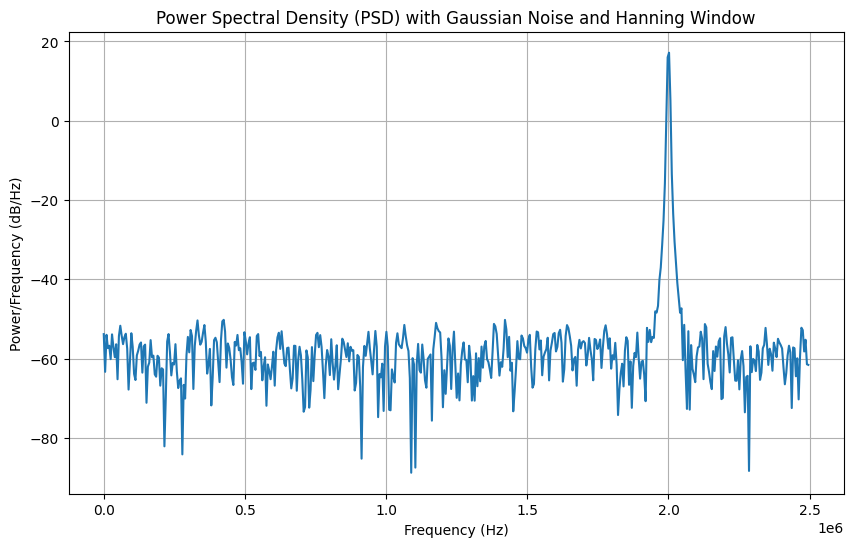

SNR from PSD with Hanning window: 71.95 dB


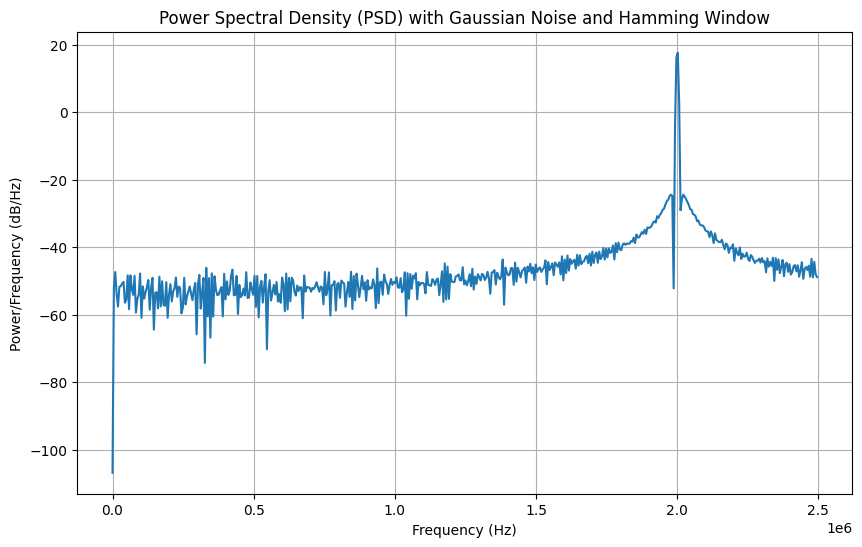

SNR from PSD with Hamming window: 57.44 dB


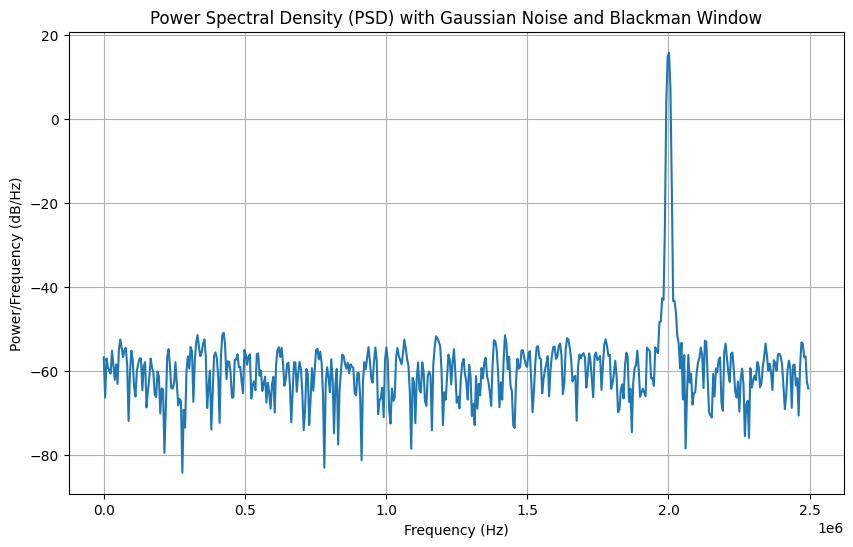

SNR from PSD with Blackman window: 73.84 dB


In [36]:
# Define window functions
windows = {'Hanning': np.hanning(N), 'Hamming': np.hamming(N), 'Blackman': np.blackman(N)}

for window_name, window in windows.items():
    # Apply window to the noisy signal
    windowed_signal = noisy_signal * window

    # Calculate and plot the PSD of the windowed signal
    freq, psd = calculate_psd(windowed_signal, Fs)

    # Plot the PSD
    plt.figure(figsize=(10, 6))
    plt.plot(freq, 10*np.log10(psd))  # Plot in dB
    plt.title(f'Power Spectral Density (PSD) with Gaussian Noise and {window_name} Window')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(True)
    plt.show()

    # Calculate SNR from PSD (accounting for windowing)
    signal_index = np.argmin(np.abs(freq - F))
    signal_power_psd = psd[signal_index]

    # Estimate noise power, excluding the signal band.  This is approximate.
    noise_indices = np.where(np.abs(freq - F) > Fs / N * 5)  # Exclude a small band around the signal
    noise_power_psd = np.mean(psd[noise_indices])

    SNR_psd_dB = 10 * np.log10(signal_power_psd / noise_power_psd)

    print(f"SNR from PSD with {window_name} window: {SNR_psd_dB:.2f} dB")

## 2. Quantization

### (a) Create a perfect quantizer with 6 bits of resolution and flexible sampling rate
- For a 200 MHz full-scale input tone, sample and quantize the sinewave at 400 MHz.
- Plot the PSD of 30 periods.
- What is the SNR?
- Repeat the SNR calculation for 100 periods of the same signal.
- Make conclusions about periodicity of quantization noise and its impact on SNR.
- How can you solve this problem?


### (b) Find an incommensurate sampling frequency
- Choose a sampling frequency larger than the Nyquist rate.
- Plot the PSD of the new samples.
- Calculate the SNR from the figure.

### (c) Repeat (a) using a 12-bit quantizer
- Can you prove from simulations that SNR ~ 6N (where N is the number of bits used) for both cases, N = 6 and N = 12?

### (d) Apply a Hanning window
- Repeat (c) with a Hanning window.
- What is the SNR?
- Make your own conclusions.

### (e) Add noise and analyze SNR
- Add noise such that the signal SNR is 38 dB.
- Repeat (c) and (d).
- What are the SNRs?
- Provide conclusions.

**HINT:** Write a Python function using `numpy.round` to perform quantization on your waveform.